## Implementation of the paper 'Image noise types recognition using convolutional neural network with principal components analysis'

#### doi: 10.1049/iet-ipr.2017.0374
##### Hui Ying Khaw1
##### Foo Chong Soon1
##### Joon Huang Chuah1
##### Chee-Onn Chow1'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

plt.style.use("dark_background")


In [2]:
# Setting up the CNN model based on architecture proposed by paper.

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

model.add(layers.Input(shape=(64, 64, 1)))

# Convolutional layers
model.add(layers.Conv2D(5, (3, 3),  padding='same'))
model.add(layers.Dropout(0.1)) 

# Max-pooling layers
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Convolutional layers
model.add(layers.Conv2D(50, (8, 8),  padding='same'))
model.add(layers.Dropout(0.1)) 

# Max-pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# Flatten the output for the fully connected layer
model.add(layers.Flatten())

# Softmax classifier
model.add(layers.Dense(4, activation='softmax'))
 
# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 5)         50        
                                                                 
 dropout (Dropout)           (None, 64, 64, 5)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 5)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        16050     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 50)        0         
 g2D)                                                   

In [3]:
# Types of noise the model will support:
NOISE_TYPE_IMPULSE = 0
NOISE_TYPE_GAUSSIAN = 1
NOISE_TYPE_SPECKLE = 2
NOISE_TYPE_POISSON = 3

# Ranges for noise types
IMPULSE_LOW_PROBABILITY = 0.025
IMPULSE_HIGH_PROBABILITY = 0.05
GAUSSIAN_LOW_SIGMA = 0.5
GAUSSIAN_HIGH_SIGMA = 0.7
SPECKLE_LOW_PROBABILITY = 0.1
SPECKLE_HIGH_PROBABILITY = 0.25
POISSON_LOW_SCALE_FACTOR = 2e+1
POISSON_HIGH_SCALE_FACTOR = 70

In [4]:
0# Add noise to the images (Train images is from LGG dataset)

lgg_dataset_dir = '../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m'

lgg_training_files = []

for root, folder_name, file_names in os.walk(lgg_dataset_dir):
    for file_name in file_names:
        if "mask" not in file_name:  # Exclude files with 'mask' in their names
            file_path = os.path.join(root, file_name)
            lgg_training_files.append(file_path)
        
print(lgg_training_files[0])

../../../Dataset/LGGSegmentationDataset/archive/kaggle_3m\data.csv


In [5]:
print('num of images: ', len(lgg_training_files))

num of images:  3931


In [6]:

# Load 4000 images from dataset.

imgs = []

for i in range(2, 3900):
    img = cv2.imread(lgg_training_files[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))

    imgs.append(img)

image shape:  (64, 64)


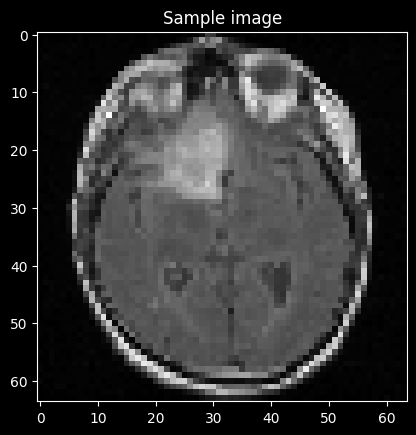

In [7]:

plt.title('Sample image')
plt.imshow(imgs[3], cmap='gray')
print('image shape: ', imgs[3].shape)

In [8]:
# Functions to add noise to image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)

    # Add salt noise
    num_salt = np.ceil(salt_prob * image.size).astype(int)
    salt_coords = [np.random.randint(0, high=image.shape[0], size=num_salt),
                   np.random.randint(0, high=image.shape[1], size=num_salt)]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = np.ceil(pepper_prob * image.size).astype(int)
    pepper_coords = [np.random.randint(0, high=image.shape[0], size=num_pepper),
                     np.random.randint(0, high=image.shape[1], size=num_pepper)]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def add_gaussian_noise(image, mean=0, stddev=2):
    noisy_image = image.copy()

    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image[:, :], noise)
    
    return noisy_image

def add_speckle_noise(image, stddev=0.1):
    noisy_image = image.copy()
    
    noise = np.random.normal(0, stddev, image.shape)
    noisy_image[:, :] = np.uint8(np.clip(image[:, :] + image[:, :] * noise, 0, 255))
    
    return noisy_image

def add_poisson_noise(image, scale):
    noisy_image = image.copy()

    noise = np.random.poisson(scale, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return noisy_image

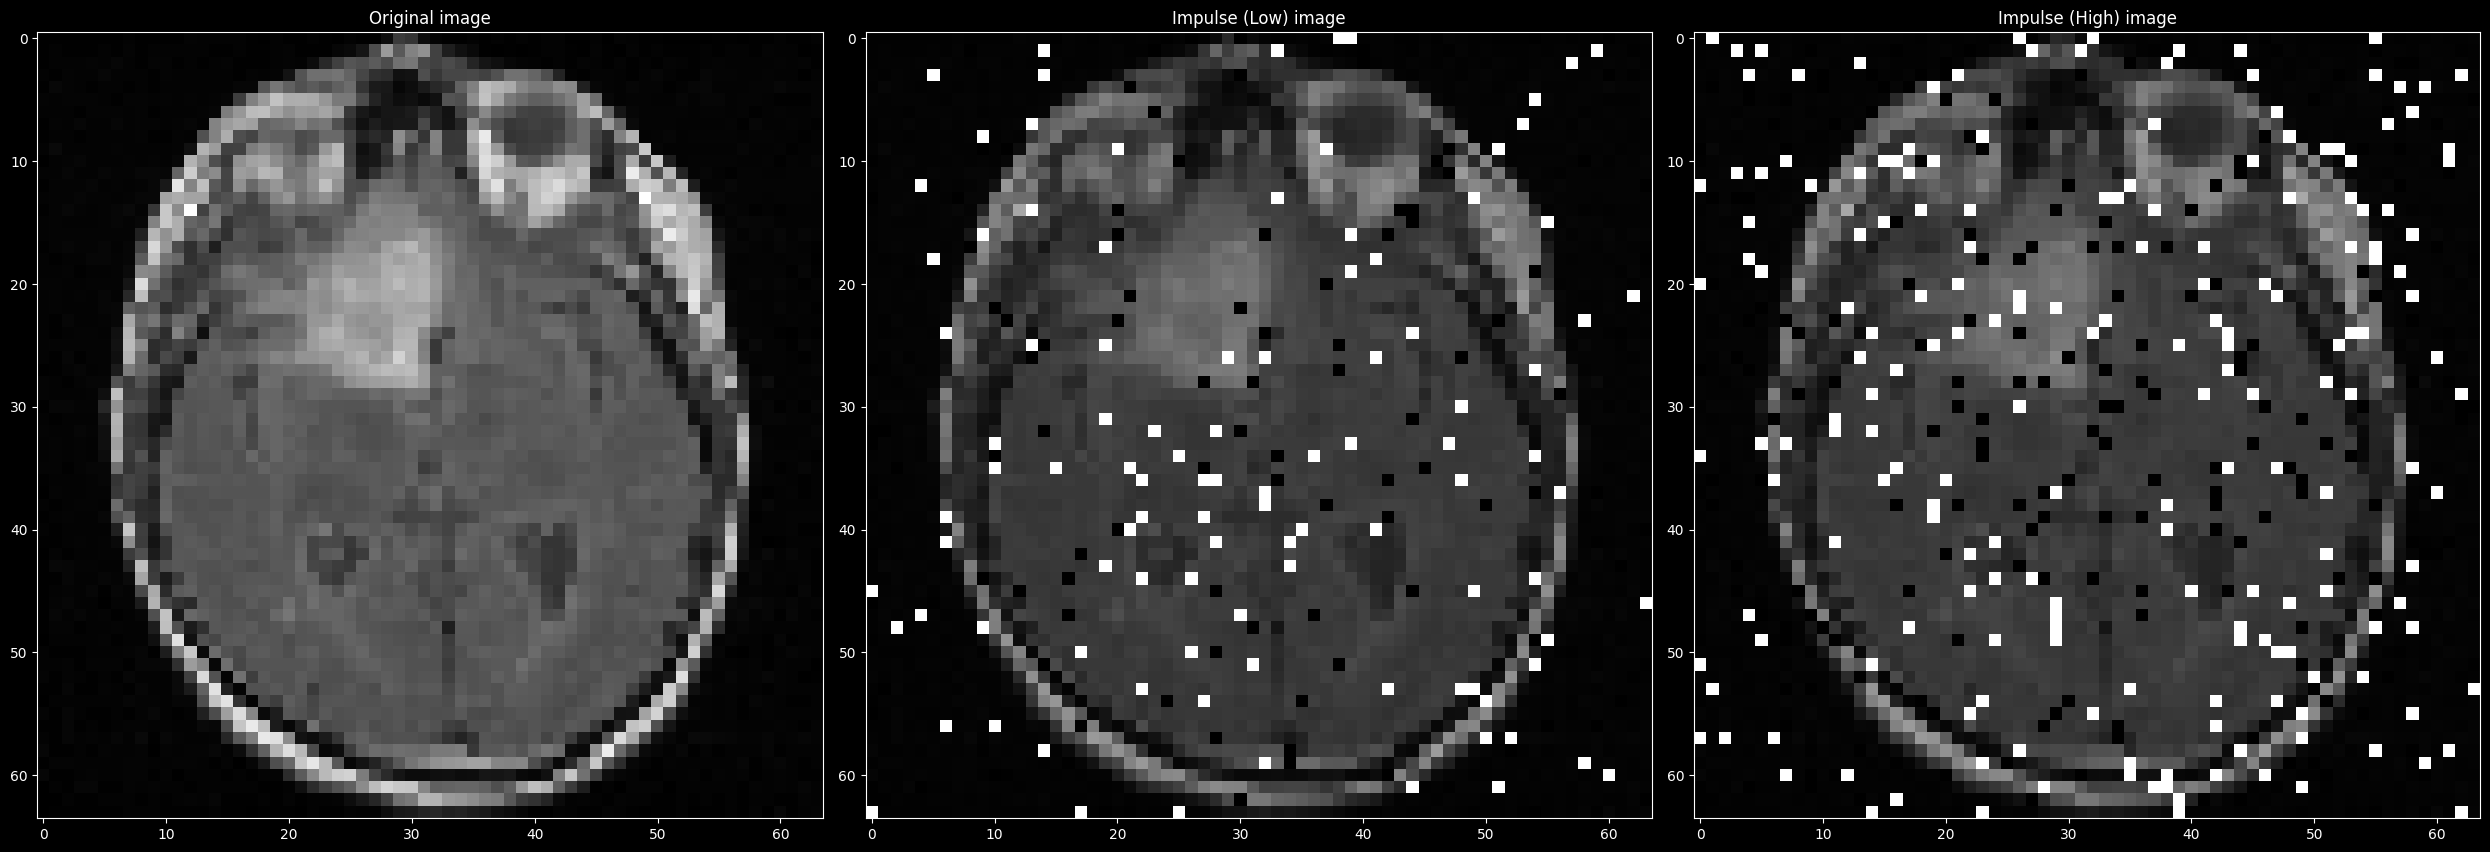

In [9]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]
fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Impulse (Low) image')
axes[1].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Impulse (High) image')
axes[2].imshow(add_salt_and_pepper_noise(test_img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

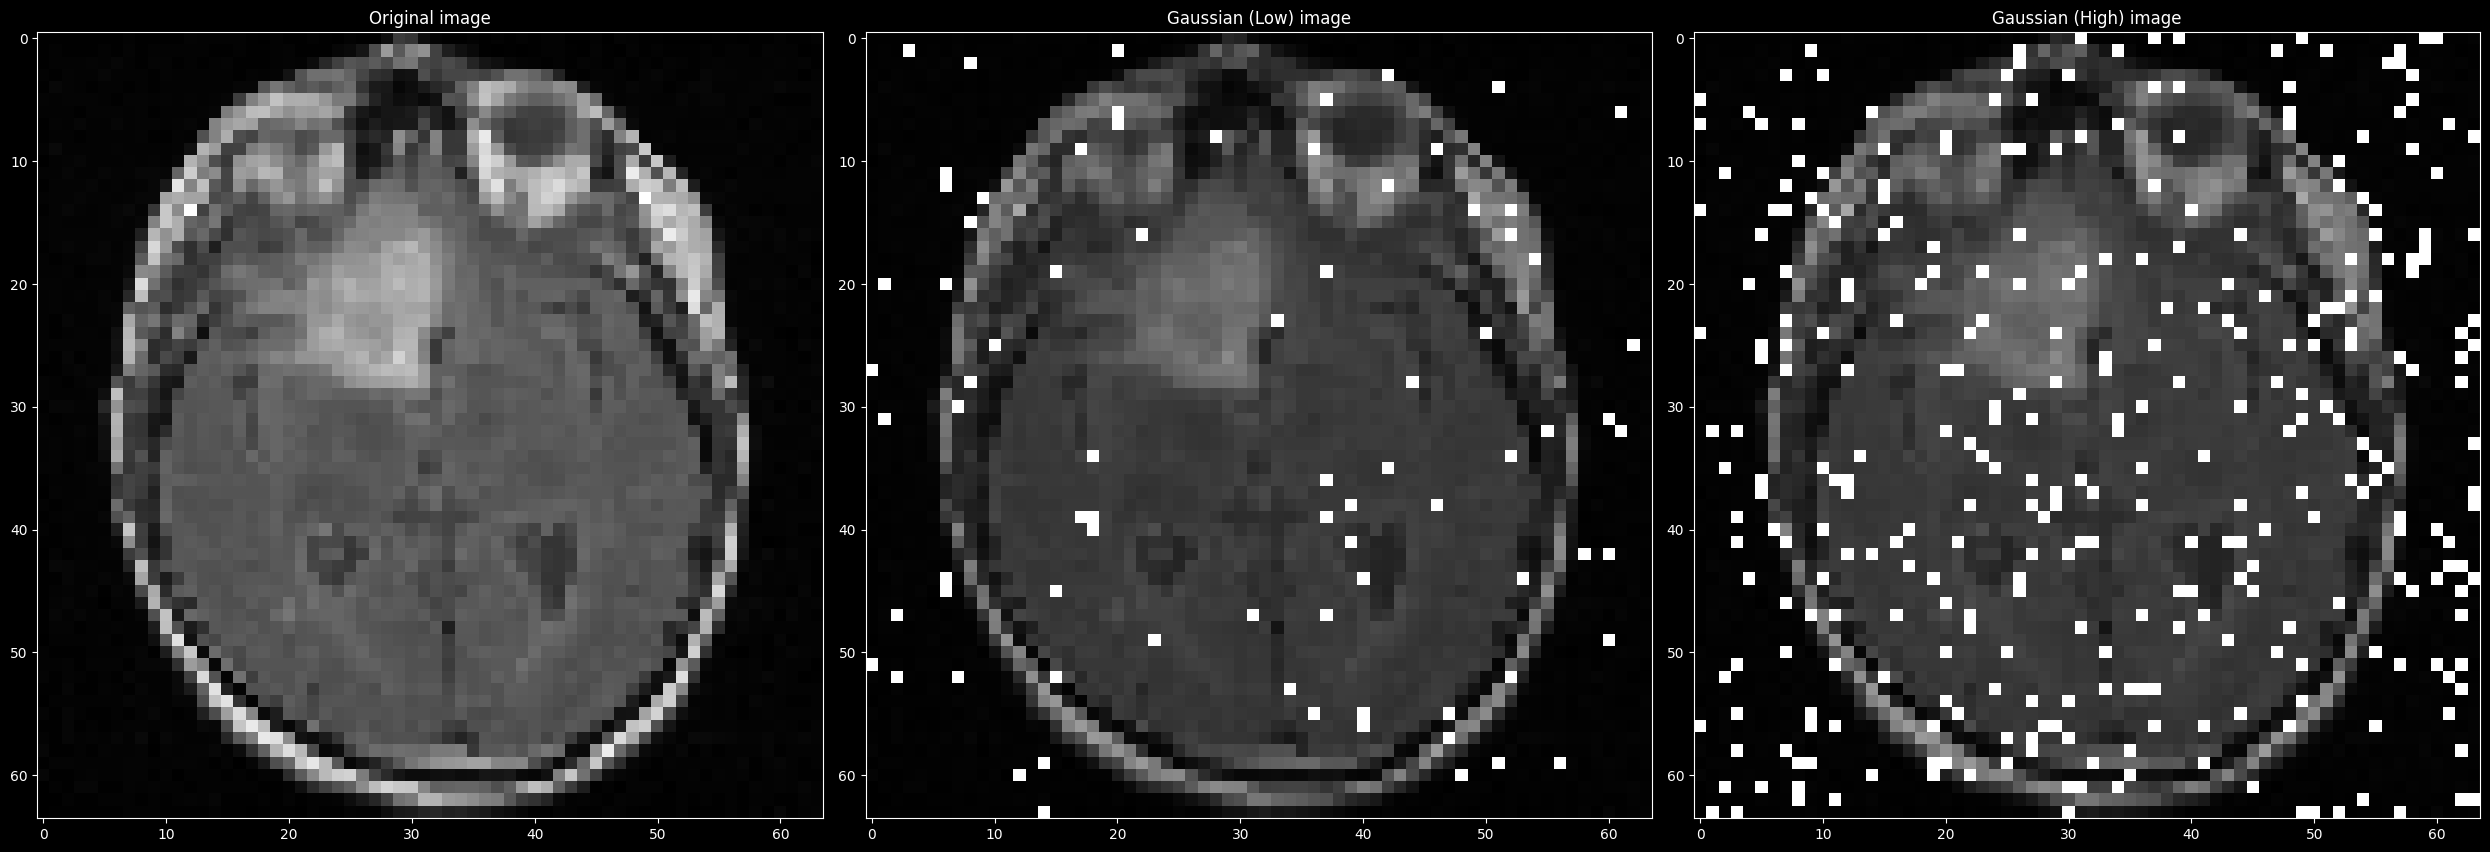

In [10]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Gaussian (Low) image')
axes[1].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_LOW_SIGMA), cmap='gray')  

axes[2].set_title('Gaussian (High) image')
axes[2].imshow(add_gaussian_noise(test_img, 0, GAUSSIAN_HIGH_SIGMA), cmap='gray')  

plt.tight_layout()  
plt.show()

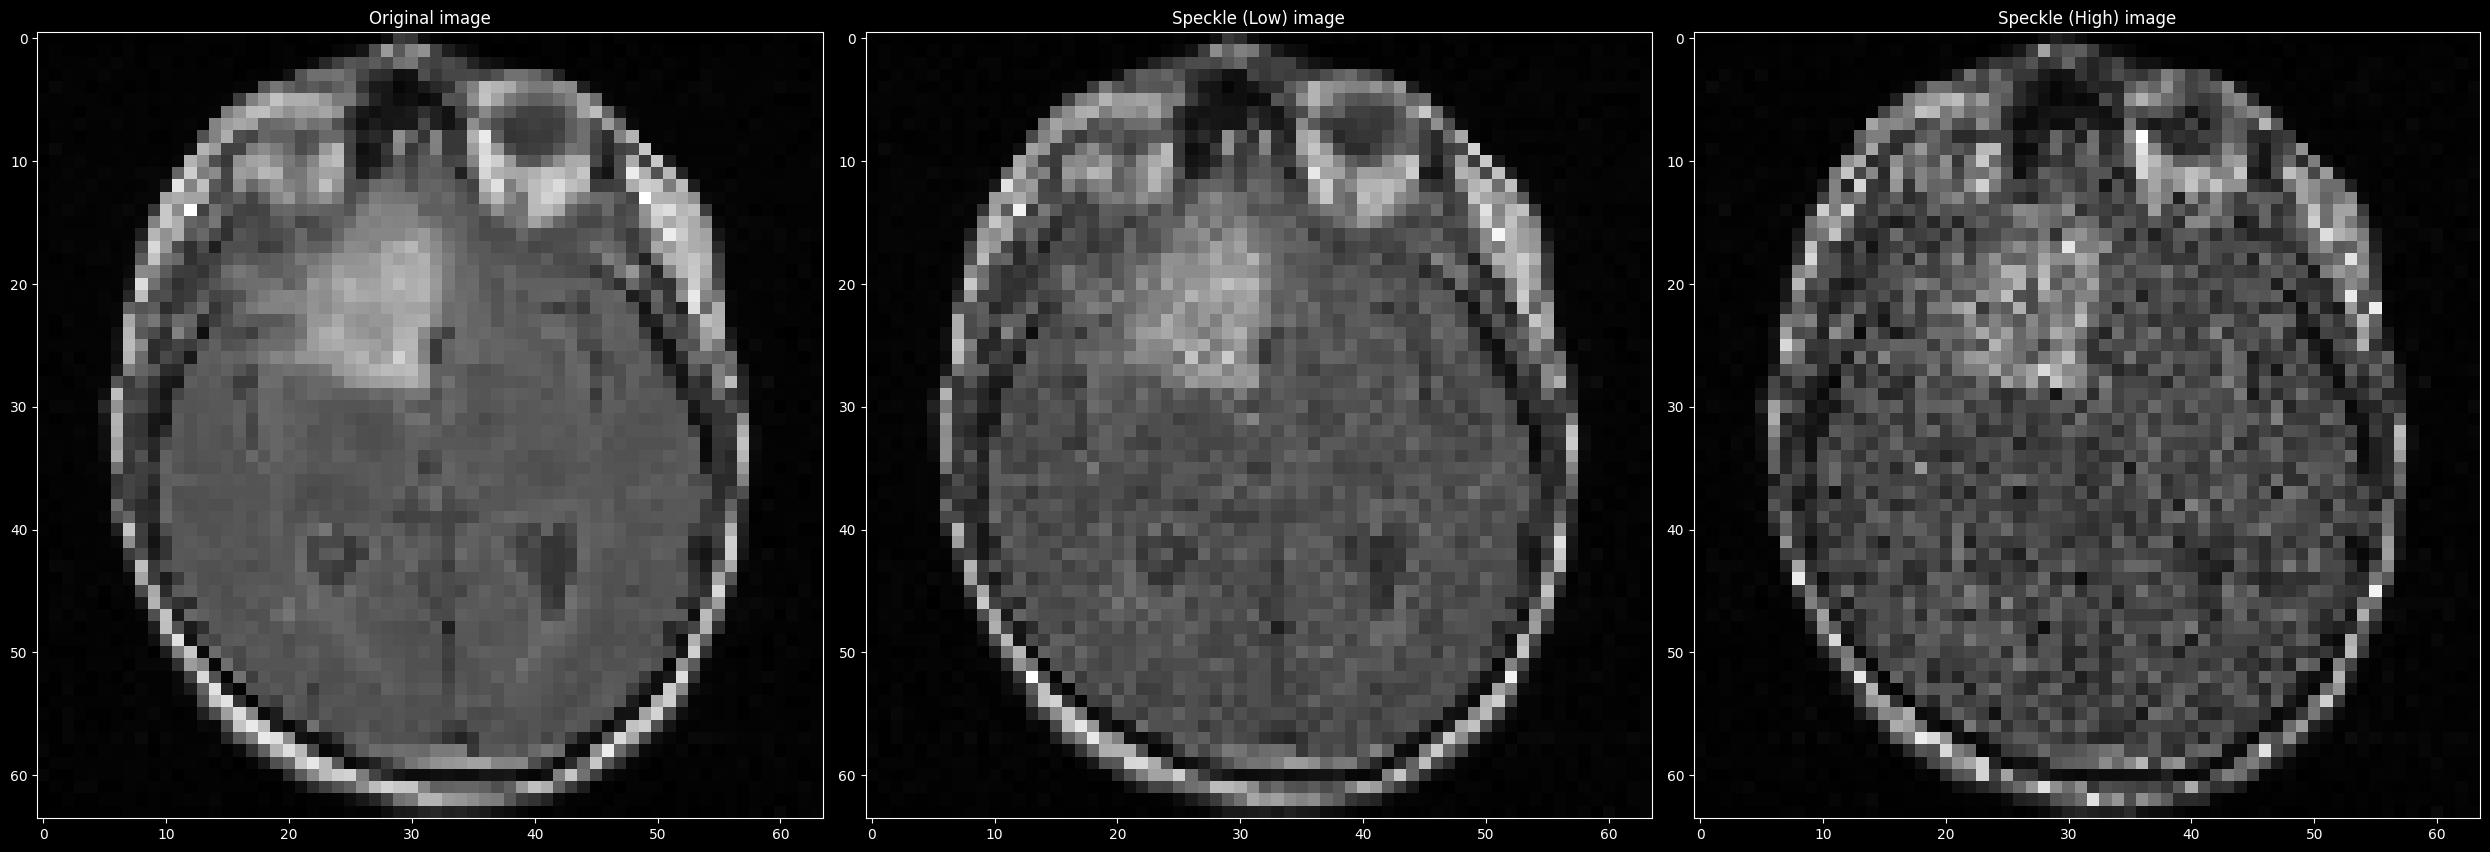

In [11]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Speckle (Low) image')
axes[1].imshow(add_speckle_noise(test_img, SPECKLE_LOW_PROBABILITY), cmap='gray')  

axes[2].set_title('Speckle (High) image')
axes[2].imshow(add_speckle_noise(test_img, SPECKLE_HIGH_PROBABILITY), cmap='gray')  

plt.tight_layout()  
plt.show()

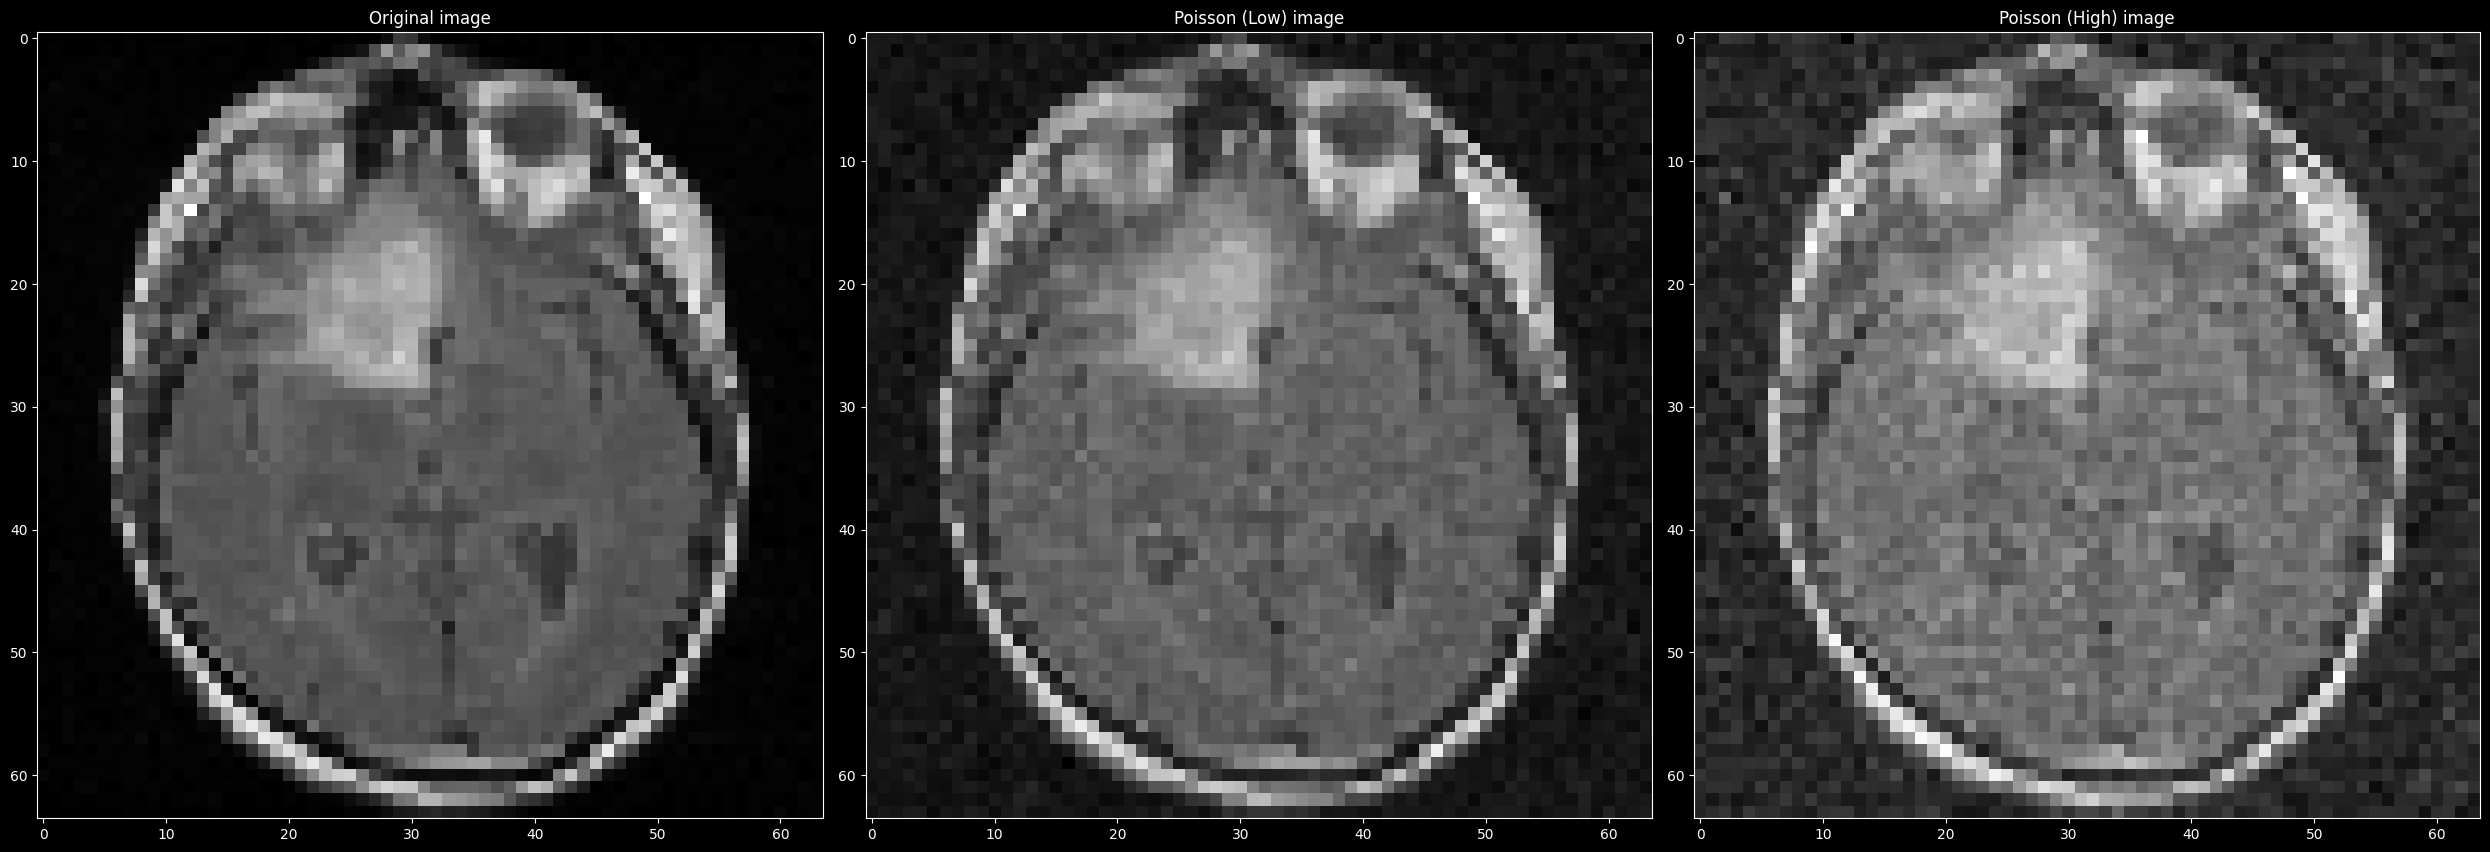

In [12]:
# Test : Add noise to images (Of all combinations and display)

test_img = imgs[3]

fig, axes = plt.subplots(1, 3, figsize=(25, 25))  

axes[0].set_title('Original image')
axes[0].imshow(test_img, cmap='gray')  

axes[1].set_title('Poisson (Low) image')
axes[1].imshow(add_poisson_noise(test_img, 2e+1), cmap='gray')  

axes[2].set_title('Poisson (High) image')
axes[2].imshow(add_poisson_noise(test_img, 70), cmap='gray')  

plt.tight_layout()  
plt.show()

In [13]:
# Image augmentation (Horizontal / Vertical flip / 45 degree rotation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)

In [14]:
# Setup training data
x_data = []
y_data = []

for img in imgs:
    # Impulse
    original_img = add_salt_and_pepper_noise(img, IMPULSE_LOW_PROBABILITY, IMPULSE_LOW_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_IMPULSE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_IMPULSE] * len(augmented_imgs))

    # Impulse
    original_img = add_salt_and_pepper_noise(img, IMPULSE_HIGH_PROBABILITY, IMPULSE_HIGH_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_IMPULSE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_IMPULSE] * len(augmented_imgs))

    # Gaussian
    original_img = add_gaussian_noise(img, 0, GAUSSIAN_LOW_SIGMA)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_GAUSSIAN)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_GAUSSIAN] * len(augmented_imgs))

    # Gaussian
    original_img = add_gaussian_noise(img, 0, GAUSSIAN_HIGH_SIGMA)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_GAUSSIAN)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_GAUSSIAN] * len(augmented_imgs))

    # Speckle
    original_img = add_speckle_noise(img, SPECKLE_LOW_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_SPECKLE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_SPECKLE] * len(augmented_imgs))

    # Speckle
    original_img = add_speckle_noise(img, SPECKLE_HIGH_PROBABILITY)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_SPECKLE)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_SPECKLE] * len(augmented_imgs))

    # Poisson
    original_img = add_poisson_noise(img, 2e+1)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_POISSON)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_POISSON] * len(augmented_imgs))

    # Poisson
    original_img = add_poisson_noise(img, 70)
    x_data.append(original_img)
    y_data.append(NOISE_TYPE_POISSON)

    augmented_imgs = datagen.random_transform(np.expand_dims(original_img, axis=0))
    x_data.extend(augmented_imgs)
    y_data.extend([NOISE_TYPE_POISSON] * len(augmented_imgs))


In [15]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_data = np.expand_dims(x_data, axis=3) / 255.0

print('x_data len: ', len(x_data))
print('x shape: ', x_data[0].shape)
print('y_data len: ', len(y_data))

x_data len:  62368
x shape:  (64, 64, 1)
y_data len:  62368


In [16]:
# Splitting data into train, test and validation

from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=104, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=104, test_size=0.25)

In [17]:
# Make the 256, 256 images into 256, 256, 1
x_train
print(x_train.shape)

(35082, 64, 64, 1)


In [18]:
print('x train len ', len(x_train))
print('x test len ', len(x_test))
print('x val len ', len(x_val))
print('x train image shape', x_train[1].shape)
print('y train len ', len(y_train))

x train len  35082
x test len  15592
x val len  11694
x train image shape (64, 64, 1)
y train len  35082


In [19]:
# Convert y data to categorical
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)
#y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)

print(y_train[0])

0


In [20]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=4)

Epoch 1/10
8771/8771 [==============================] - 124s 14ms/step - loss: 0.4027 - accuracy: 0.7825 - val_loss: 0.3384 - val_accuracy: 0.8232
Epoch 2/10
8771/8771 [==============================] - 126s 14ms/step - loss: 0.3259 - accuracy: 0.8422 - val_loss: 0.2883 - val_accuracy: 0.8637
Epoch 3/10
8771/8771 [==============================] - 132s 15ms/step - loss: 0.2849 - accuracy: 0.8710 - val_loss: 0.7394 - val_accuracy: 0.7608
Epoch 4/10
8771/8771 [==============================] - 141s 16ms/step - loss: 0.2697 - accuracy: 0.8831 - val_loss: 0.3455 - val_accuracy: 0.8655
Epoch 5/10
8771/8771 [==============================] - 132s 15ms/step - loss: 0.2478 - accuracy: 0.8948 - val_loss: 0.2791 - val_accuracy: 0.8784
Epoch 6/10
8771/8771 [==============================] - 128s 15ms/step - loss: 0.2275 - accuracy: 0.9053 - val_loss: 0.2337 - val_accuracy: 0.9038
Epoch 7/10
8771/8771 [==============================] - 129s 15ms/step - loss: 0.1212 - accuracy: 0.9522 - val_loss: 0

In [21]:
metrics = model.evaluate(x_test, y_test)
print(metrics)

488/488 [==============================] - 5s 10ms/step - loss: 0.1349 - accuracy: 0.9573
[0.1349247246980667, 0.9573498964309692]


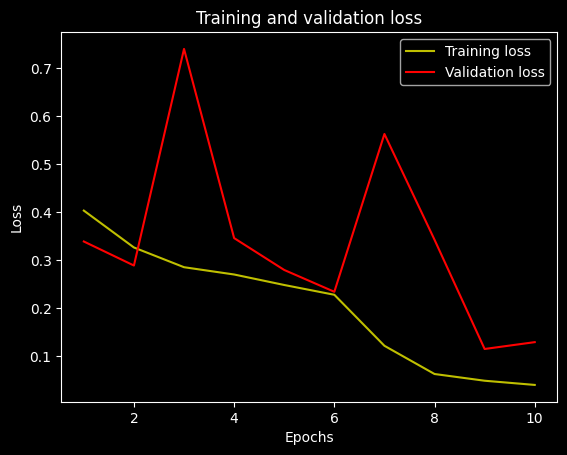

{'loss': [0.4027429223060608, 0.3259398639202118, 0.2848643660545349, 0.2696850895881653, 0.24784019589424133, 0.22747820615768433, 0.1212281733751297, 0.06250402331352234, 0.04849482327699661, 0.039766620844602585], 'accuracy': [0.7825095653533936, 0.8421697616577148, 0.870959460735321, 0.8831309676170349, 0.8948463797569275, 0.9053075909614563, 0.9521691799163818, 0.9775668382644653, 0.9827831983566284, 0.9858331680297852], 'val_loss': [0.3384135961532593, 0.28834280371665955, 0.7393617033958435, 0.3454645872116089, 0.27911871671676636, 0.23369641602039337, 0.5622485280036926, 0.3420129418373108, 0.11460653692483902, 0.12883181869983673], 'val_accuracy': [0.8232426643371582, 0.8636907935142517, 0.7608175277709961, 0.8654865622520447, 0.8783991932868958, 0.9037967920303345, 0.8351291418075562, 0.8954164385795593, 0.9611766934394836, 0.958611249923706]}


In [22]:
history = hist

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

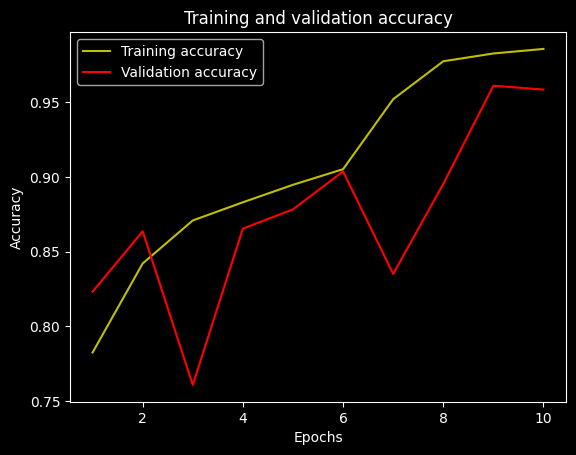

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

488/488 [==============================] - 6s 12ms/step
y pred :  2
actual noise type (index) :  2


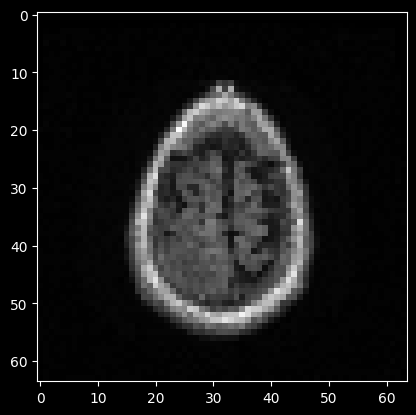

y pred :  3
actual noise type (index) :  3


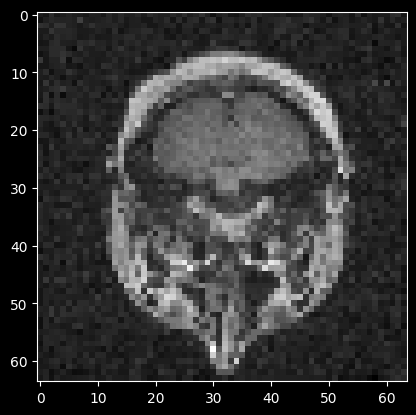

y pred :  3
actual noise type (index) :  3


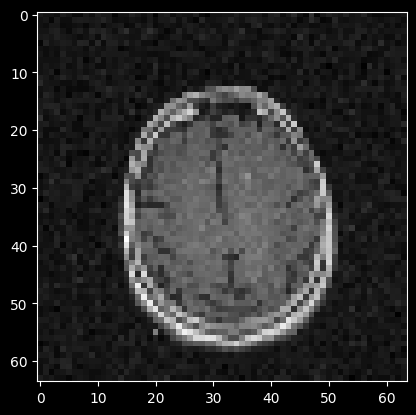

y pred :  3
actual noise type (index) :  3


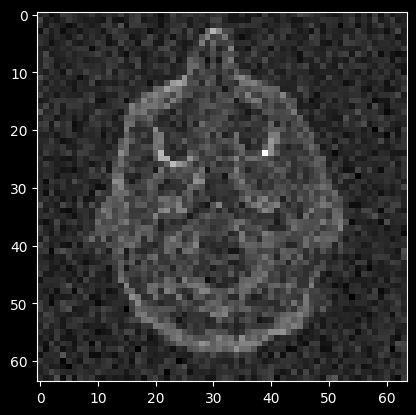

y pred :  0
actual noise type (index) :  0


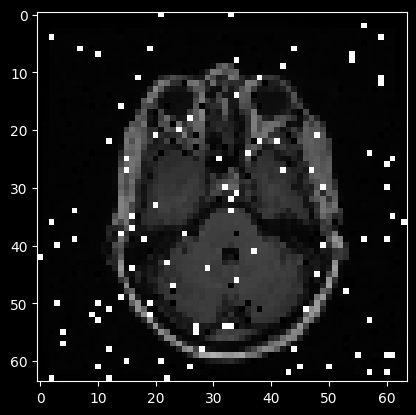

y pred :  1
actual noise type (index) :  1


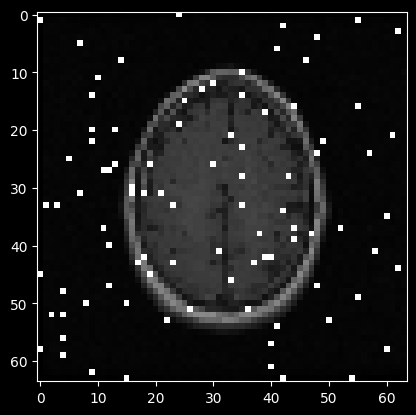

y pred :  2
actual noise type (index) :  2


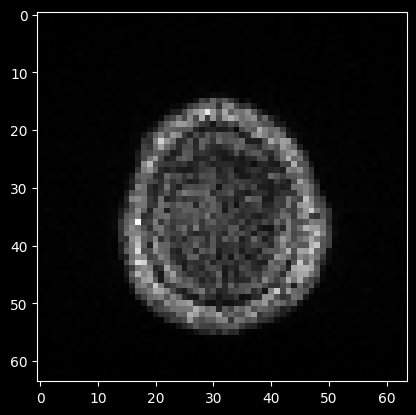

y pred :  0
actual noise type (index) :  0


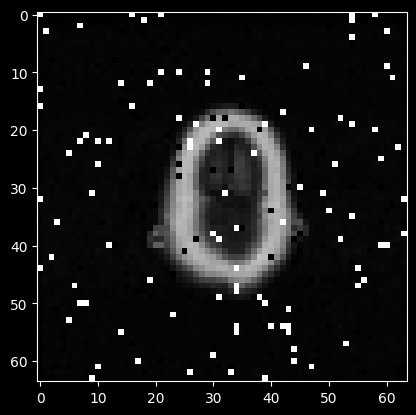

y pred :  1
actual noise type (index) :  1


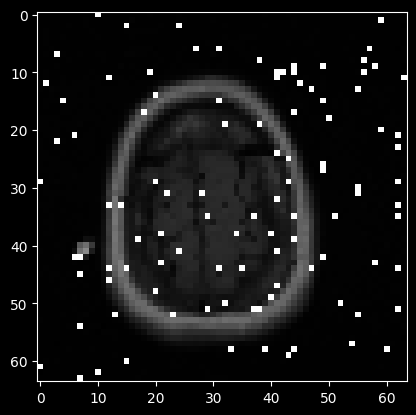

y pred :  1
actual noise type (index) :  1


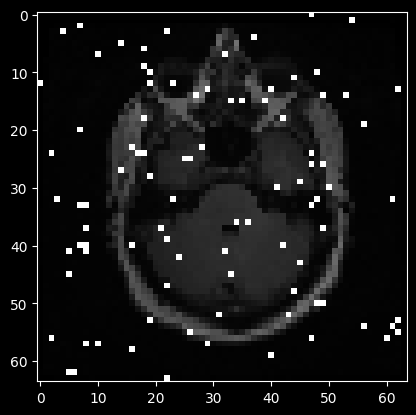

In [26]:
# Some predictions to see how the model performs.
y_pred=model.predict(x_test)

for i in range(10):
    plt.imshow(x_test[i], cmap='gray')
    print('y pred : ', np.argmax(y_pred[i]))
    print('actual noise type (index) : ', y_test[i])
    plt.show()

In [27]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
122/122 [==============================] - 5s 41ms/step - loss: 0.1349 - accuracy: 0.9573
test loss, test acc: [0.13492469489574432, 0.9573498964309692]
